In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime as dt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
sns.set_palette(sns.color_palette('tab20', 20))
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from datetime import date, timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', 999)
np.random.seed(1987)

In [2]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
start = dt.datetime.now()

data_dir = '../input/kaggle-survey-2018/'
META_DATA_PATH = '../input/meta-kaggle/'
questions = pd.read_csv(os.path.join(data_dir, 'SurveySchema.csv'))
responses = pd.read_csv(os.path.join(data_dir, 'multipleChoiceResponses.csv'), low_memory=False)
responses['cnt'] = 1
target_order = pd.DataFrame({
    'Q26': ['Definitely not', 'Definitely yes', 'Maybe', 'Probably not', 'Probably yes'],
    'target': [0, 4, 2, 1, 3],
})
target_order = target_order.sort_values(by='target')
target_order['color'] = ['rgb(217,30,30)', 'rgb(242,143,56)', 'rgb(242,211,56)', 'rgb(10,136,186)', 'rgb(12,51,131)']
responses = responses.merge(target_order, how='left', on='Q26')
questions.shape
questions.head()
responses.shape
responses.head()

(12, 52)

,2018 Kaggle Machine Learning and Data Science Survey,Q1,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q2,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q3,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q4,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q5,Q50,Q6,Q7,Q8,Q9,Time from Start to Finish (seconds)
0,Question:,What is your gender? - Selected Choice,Does your current employer incorporate machine...,Select any activities that make up an importan...,What is the primary tool that you use at work ...,Which of the following integrated development ...,Which of the following hosted notebooks have y...,Which of the following cloud computing service...,What programming languages do you use on a reg...,What specific programming language do you use ...,What programming language would you recommend ...,What machine learning frameworks have you used...,What is your age (# years)?,Of the choices that you selected in the previo...,What data visualization libraries or tools hav...,Of the choices that you selected in the previo...,Approximately what percent of your time at wor...,How long have you been writing code to analyze...,For how many years have you used machine learn...,Do you consider yourself to be a data scientist?,Which of the following cloud computing product...,Which of the following machine learning produc...,Which of the following relational database pro...,In which country do you currently reside?,Which of the following big data and analytics ...,Which types of data do you currently interact ...,What is the type of data that you currently in...,Where do you find public datasets? (Select all...,During a typical data science project at work ...,What percentage of your current machine learni...,On which online platforms have you begun or co...,On which online platform have you spent the mo...,Who/what are your favorite media sources that ...,How do you perceive the quality of online lear...,What is the highest level of formal education ...,Which better demonstrates expertise in data sc...,How do you perceive the importance of the foll...,What metrics do you or your organization use t...,Approximately what percent of your data projec...,What do you find most difficult about ensuring...,In what circumstances would you explore model ...,Approximately what percent of your data projec...,What methods do you prefer for explaining and/...,"Do you consider ML models to be ""black boxes"" ...",What tools and methods do you use to make your...,Which best describes your undergraduate major?...,What barriers prevent you from making your wor...,Select the title most similar to your current ...,In what industry is your current employer/cont...,How many years of experience do you have in yo...,What is your current yearly compensation (appr...,Duration (in seconds)
1,# of Respondents:,23860,20670,19518,19199,19117,18971,18864,18828,15223,18789,18697,23860,12990,18593,12185,18548,18534,18492,18481,11060,10887,10719,23860,9746,16922,13879,16816,15938,15746,15672,9671,16338,15980,23439,15880,14937,13584,13120,13344,13653,13290,13418,13369,12891,22948,12814,22901,21686,21102,20186,23860
2,Who was excluded? (0 = not excluded; 1 = exclu...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,If What is your age (# years)? 0-17 Is Selecte...,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4,If What is the highest level of formal educati...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


(23860, 398)

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,Q14_Part_6,Q14_Part_7,Q14_Part_8,Q14_Part_9,Q14_Part_10,Q14_Part_11,Q14_OTHER_TEXT,Q15_Part_1,Q15_Part_2,Q15_Part_3,Q15_Part_4,Q15_Part_5,Q15_Part_6,Q15_Part_7,Q15_OTHER_TEXT,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_Part_13,Q16_Part_14,Q16_Part_15,Q16_Part_16,Q16_Part_17,Q16_Part_18,Q16_OTHER_TEXT,Q17,Q17_OTHER_TEXT,Q18,Q18_OTHER_TEXT,Q19_Part_1,Q19_Part_2,Q19_Part_3,Q19_Part_4,Q19_Part_5,Q19_Part_6,Q19_Part_7,Q19_Part_8,Q19_Part_9,Q19_Part_10,Q19_Part_11,Q19_Part_12,Q19_Part_13,Q19_Part_14,Q19_Part_15,Q19_Part_16,Q19_Part_17,Q19_Part_18,Q19_Part_19,Q19_OTHER_TEXT,Q20,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_Part_6,Q21_Part_7,Q21_Part_8,Q21_Part_9,Q21_Part_10,Q21_Part_11,Q21_Part_12,Q21_Part_13,Q21_OTHER_TEXT,Q22,Q22_OTHER_TEXT,Q23,Q24,Q25,Q26,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_Part_7,Q27_Part_8,Q27_Part_9,Q27_Part_10,Q27_Part_11,Q27_Part_12,Q27_Part_13,Q27_Part_14,Q27_Part_15,Q27_Part_16,Q27_Part_17,Q27_Part_18,Q27_Part_19,Q27_Part_20,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_Part_13,Q28_Part_14,Q28_Part_15,Q28_Part_16,Q28_Part_17,Q28_Part_18,Q28_Part_19,Q28_Part_20,Q28_Part_21,Q28_Part_22,Q28_Part_23,Q28_Part_24,Q28_Part_25,Q28_Part_26,Q28_Part_27,Q28_Part_28,Q28_Part_29,Q28_Part_30,Q28_Part_31,Q28_Part_32,Q28_Part_33,Q28_Part_34,Q28_Part_35,Q28_Part_36,Q28_Part_37,Q28_Part_38,Q28_Part_39,Q28_Part_40,Q28_Part_41,Q28_Part_42,Q28_Part_43,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_Part_13,Q29_Part_14,Q29_Part_15,Q29_Part_16,Q29_Part_17,Q29_Part_18,Q29_Part_19,Q29_Part_20,Q29_Part_21,Q29_Part_22,Q29_Part_23,Q29_Part_24,Q29_Part_25,Q29_Part_26,Q29_Part_27,Q29_Part_28,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_Part_13,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32,Q32_OTHER,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_OTHER_TEXT,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6,Q35_OTHER_TEXT,Q36_Part_1,Q36_Part_2,Q36_Part_3,Q36_Part_4,Q36_Part_5,Q36_Part_6,Q36_Part_7,Q36_Part_8,Q36_Part_9,Q36_Part_10,Q36_Part_11,Q36_Part_12,Q36_Part_13,Q36_OTHER_TEXT,Q37,Q37_OTHER_TEXT,Q38_Part_1,Q38_Part_2,Q38_Part_3,Q38_Part_4,Q38_Part_5,Q38_Part_6,Q38_Part_7,Q38_Part_8,Q38_Part_9,Q38_Part_10,Q38_Part_11,Q38_Part_12,Q38_Part_13,Q38_Part_14,Q38_Part_15,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22,Q38_OTHER_TEXT,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,Q42_OTHER_TEXT,Q43,Q44_Part_1,Q44_Part_2,Q44_Part_3,Q44_Part_4,Q44_Part_5,Q44_Part_6,Q45_Part_1,Q45_Part_2,Q45_P

In [3]:
q26 = responses[1:].groupby(['Q26', 'target'])[['cnt']].count().sort_values(by='target').reset_index()
q26

,Q26,target,cnt
0,Definitely not,0.0,1557
1,Probably not,1.0,3162
2,Maybe,2.0,4184
3,Probably yes,3.0,4893
4,Definitely yes,4.0,4684


In [5]:
data = [
go.Bar(
    x = q26.Q26.values,
    y = q26.cnt.values,
    marker=dict(color=-q26['target'].values, colorscale='Portland', showscale=False)
),
]
layout= go.Layout(
    title= 'Do you consider yourself to be a data scientist?',
    yaxis=dict(title='# of Respondents:', ticklen=5, gridwidth=2),
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='q26')

In [6]:
responses[['Q24', 'Q25', 'Q26']][:2]

,Q24,Q25,Q26
0,How long have you been writing code to analyze...,For how many years have you used machine learn...,Do you consider yourself to be a data scientist?
1,I have never written code but I want to learn,I have never studied machine learning but plan...,Maybe


In [7]:
q24_clean = pd.DataFrame({
    'Q24': ['I have never written code and I do not want to learn',
       '40+ years', '30-40 years', '20-30 years',
       'I have never written code but I want to learn', '10-20 years',
       '5-10 years', '3-5 years', '< 1 year', '1-2 years'],
    'q24_clean': ['None', '10+', '10+', '10+', 'None', '10+', '5-10', '3-5', '<1', '1-2'],
    'f24': [-1, 10, 10, 10, -1, 10, 7.5, 4, 0.5, 1.5]
})
enhanced_responses = responses.merge(q24_clean, on='Q24')
q24_cross = enhanced_responses[1:].groupby([
    'Q26', 'target', 'color', 'q24_clean', 'f24'])[['cnt']].count().reset_index().sort_values(by='f24')
q24_cross

,Q26,target,color,q24_clean,f24,cnt
29,Probably yes,3.0,"rgb(10,136,186)",None,-1.0,130
23,Probably not,1.0,"rgb(242,143,56)",None,-1.0,191
5,Definitely not,0.0,"rgb(217,30,30)",None,-1.0,227
17,Maybe,2.0,"rgb(242,211,56)",None,-1.0,182
11,Definitely yes,4.0,"rgb(12,51,131)",None,-1.0,125
22,Probably not,1.0,"rgb(242,143,56)",<1,0.5,1089
4,Definitely not,0.0,"rgb(217,30,30)",<1,0.5,670
16,Maybe,2.0,"rgb(242,211,56)",<1,0.5,1111
28,Probably yes,3.0,"rgb(10,136,186)",<1,0.5,886
10,Definitely yes,4.0,"rgb(12,51,131)",<1,0.5,767


In [8]:
data = []
for ds in target_order.Q26.values:
    df = q24_cross[q24_cross.Q26 == ds]
    data.append(
        go.Bar(x=df.q24_clean.values, y=df.cnt.values,
               marker=dict(color=df.color.values),
               name=ds)
    )
layout= go.Layout(
    title= 'Data Analysis Experience',
    xaxis= dict(title='How long have you been writing code to analyze data? (years)', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Data Scientist Confidence', ticklen=5, gridwidth=2),
    showlegend=True
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='data-code')

In [9]:
q25_clean = pd.DataFrame({
    'Q25': ['I have never studied machine learning and I do not plan to',
       '20+ years', '10-15 years', '4-5 years', '5-10 years', '3-4 years',
       'I have never studied machine learning but plan to learn in the future',
       '2-3 years', '1-2 years', '< 1 year'],
    'q25_clean': ['None', '4+', '4+', '4+', '4+', '3-4', 'None', '2-3', '1-2', '<1'],
    'f25': [-1, 5, 5, 5, 5, 3.5, -1, 2.5, 1.5, 0.5]
})
enhanced_responses = responses.merge(q25_clean, on='Q25')
q26_cross = enhanced_responses[1:].groupby([
    'Q26', 'target', 'color', 'q25_clean', 'f25'])[['cnt']].count().reset_index().sort_values(by='f25')
q26_cross

,Q26,target,color,q25_clean,f25,cnt
29,Probably yes,3.0,"rgb(10,136,186)",None,-1.0,293
23,Probably not,1.0,"rgb(242,143,56)",None,-1.0,525
5,Definitely not,0.0,"rgb(217,30,30)",None,-1.0,448
17,Maybe,2.0,"rgb(242,211,56)",None,-1.0,394
11,Definitely yes,4.0,"rgb(12,51,131)",None,-1.0,253
22,Probably not,1.0,"rgb(242,143,56)",<1,0.5,1462
4,Definitely not,0.0,"rgb(217,30,30)",<1,0.5,781
16,Maybe,2.0,"rgb(242,211,56)",<1,0.5,1620
28,Probably yes,3.0,"rgb(10,136,186)",<1,0.5,1334
10,Definitely yes,4.0,"rgb(12,51,131)",<1,0.5,1070


In [10]:
data = []
for ds in target_order.Q26.values:
    df = q26_cross[q26_cross.Q26 == ds]
    data.append(
        go.Bar(x=df.q25_clean.values, y=df.cnt.values,
               marker=dict(color=df.color.values),
               name=ds)
    )
layout= go.Layout(
    title= 'Machine Learning Experience',
    xaxis= dict(title='Machine Learning Experience (years)', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Data Scientist Confidence', ticklen=5, gridwidth=2),
    showlegend=True
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='mlexp')

In [11]:
q6_cnt = responses[1:].groupby(['Q6'])[['cnt']].count().reset_index()
q6_mean = responses[1:].groupby(['Q6'])[['target']].mean().reset_index()

q6_clean = pd.merge(q6_cnt, q6_mean, on='Q6')
q6_clean.columns = ['Q6', 'Q6_cnt', 'Q6_dsc'] 
q6_clean = q6_clean.sort_values(by='Q6_dsc', ascending=False)
q6_clean
enhanced_responses = responses.merge(q6_clean, on='Q6')

q6_cross = enhanced_responses[1:].groupby([
    'Q6', 'Q6_cnt', 'Q6_dsc', 'Q26', 'target', 'color'])[['cnt']].count().reset_index().sort_values(by='Q6_dsc')
q6_cross = q6_cross[q6_cross.Q6_cnt > 500]
q6_cross

,Q6,Q6_cnt,Q6_dsc
7,Data Scientist,4137,3.424319
13,Principal Investigator,97,2.906977
19,Statistician,237,2.731707
16,Research Scientist,1189,2.630350
1,Chief Officer,360,2.584665
5,Data Engineer,737,2.436573
4,Data Analyst,1922,2.404595
15,Research Assistant,600,2.389452
6,Data Journalist,20,2.333333
11,Not employed,842,2.243572


,Q6,Q6_cnt,Q6_dsc,Q26,target,color,cnt
91,Software Engineer,3130,1.946386,Maybe,2.0,"rgb(242,211,56)",650
93,Software Engineer,3130,1.946386,Probably yes,3.0,"rgb(10,136,186)",532
89,Software Engineer,3130,1.946386,Definitely not,0.0,"rgb(217,30,30)",333
92,Software Engineer,3130,1.946386,Probably not,1.0,"rgb(242,143,56)",669
90,Software Engineer,3130,1.946386,Definitely yes,4.0,"rgb(12,51,131)",334
63,Other,1322,1.973451,Probably not,1.0,"rgb(242,143,56)",256
62,Other,1322,1.973451,Maybe,2.0,"rgb(242,211,56)",289
61,Other,1322,1.973451,Definitely yes,4.0,"rgb(12,51,131)",184
60,Other,1322,1.973451,Definitely not,0.0,"rgb(217,30,30)",181
64,Other,1322,1.973451,Probably yes,3.0,"rgb(10,136,186)",220


In [12]:
data = []
for ds in target_order.Q26.values:
    df = q6_cross[q6_cross.Q26 == ds]
    data.append(
        go.Bar(x=df.Q6.values, y=df.cnt.values,
               marker=dict(color=df.color.values),
               name=ds)
    )
layout= go.Layout(
    title= 'An individual with data scientist job title is probably a data scientist :)',
    xaxis= dict(title='Title most similar to current role', ticklen=5, zeroline=False, gridwidth=2),
    yaxis=dict(title='Data Scientist Confidence', ticklen=5, gridwidth=2),
    showlegend=True
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='job-title')

In [13]:
('<1' > '2',
 '10-15' < '3-4',
 'Doctoral degree' < 'No formal education past high school')

(True, True, True)

In [14]:
def first_number(s):
    s = s.replace('+', '-')
    s = s.replace(' ', '')
    s = s.replace(',000', '')
    s = s.replace('%', '-')
    try:
        return int(s.split('-')[0])
    except Exception:
        return np.nan

# Q1 5 23860
# What is your gender? - Selected Choice
Q1 = pd.DataFrame({'Q1': ['Female', 'Male', 'Prefer not to say', 'Prefer to self-describe']})
Q1['f1'] = [0, 1, 2, 2]
print(Q1)

# Q2 13 23860
# What is your age (# years)?
Q2 = pd.DataFrame(
    {'Q2': ['45-49', '30-34', '35-39', '22-24', '25-29', '18-21', '40-44', '55-59', '60-69',
            '50-54', '80+', '70-79']})
Q2['f2'] = Q2.Q2.apply(first_number)
print(Q2)

# Q4 8 23439
# What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Q4 = pd.DataFrame(
    {'Q4': ['Doctoral degree', 'Bachelor’s degree', 'Master’s degree', 'Professional degree',
            'Some college/university study without earning a bachelor’s degree',
            'I prefer not to answer',
            'No formal education past high school']})
Q4['f4'] = [5, 2, 3, 2, 1, np.nan, 0]
print(Q4)

# Q8 12 21102
# How many years of experience do you have in your current role?
Q8 = pd.DataFrame({'Q8': ['5-10', '0-1', '10-15', '3-4', '1-2', '2-3', '15-20', '4-5', '20-25',
                          '25-30', '30 +']})
Q8['f8'] = Q8.Q8.apply(first_number)
print(Q8)

# Q9 20 20186
# What is your current yearly compensation (approximate $USD)?
Q9 = pd.DataFrame({'Q9': ['I do not wish to disclose my approximate yearly compensation',
                          '10-20,000', '0-10,000', '20-30,000', '125-150,000', '30-40,000',
                          '50-60,000', '100-125,000', '90-100,000', '70-80,000', '80-90,000',
                          '60-70,000', '400-500,000', '40-50,000', '150-200,000', '500,000+',
                          '300-400,000', '200-250,000', '250-300,000']})
Q9['f9'] = Q9.Q9.apply(first_number)
print(Q9)

# Q10 7 20670
# Does your current employer incorporate machine learning methods into their business?
Q10 = pd.DataFrame({'Q10': [
    'I do not know',
    'No (we do not use ML methods)',
    'We are exploring ML methods (and may one day put a model into production)',
    'We recently started using ML methods (i.e., models in production for less than 2 years)',
    'We have well established ML methods (i.e., models in production for more than 2 years)',
    'We use ML methods for generating insights (but do not put working models into production)'
]})
Q10['f10'] = [-1, 0, 1, 2, 3, 1]
print(Q10)

# Q12_MULTIPLE_CHOICE 7 19199
# What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice
Q12_MULTIPLE_CHOICE = pd.DataFrame({'Q12_MULTIPLE_CHOICE': [
    'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
    'Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
    'Local or hosted development environments (RStudio, JupyterLab, etc.)',
    'Advanced statistical software (SPSS, SAS, etc.)',
    'Other',
    'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)'
]})
Q12_MULTIPLE_CHOICE['f12_MULTIPLE_CHOICE'] = [4, 1, 3, 2, -1, 1]
print(Q12_MULTIPLE_CHOICE)

# Q23 7 18548
# Approximately what percent of your time at work or school is spent actively coding?
Q23 = pd.DataFrame({'Q23': [
    '0% of my time',
    '1% to 25% of my time',
    '75% to 99% of my time',
    '50% to 74% of my time',
    '25% to 49% of my time',
    '100% of my time']})
Q23['f23'] = Q23.Q23.apply(first_number)
print(Q23)

# Q24 11 18534
# How long have you been writing code to analyze data?
Q24 = pd.DataFrame({'Q24': [
    'I have never written code but I want to learn', '5-10 years', '3-5 years', '< 1 year',
    '1-2 years', '10-20 years', '20-30 years', '30-40 years',
    'I have never written code and I do not want to learn', '40+ years'
]})
Q24['f24'] = [0, 6, 4, 0.5, 1.5, 12, 24, 30, -1, 40]
print(Q24)

# Q25 11 18492
# For how many years have you used machine learning methods (at work or in school)?
Q25 = pd.DataFrame({'Q25': [
    'I have never studied machine learning but plan to learn in the future', '< 1 year',
    '4-5 years', '2-3 years', '1-2 years', '5-10 years', '3-4 years',
    'I have never studied machine learning and I do not plan to', '20+ years', '10-15 years'
]})
Q25['f25'] = [0, 0.5, 4, 2.5, 1.5, 6, 3.5, -1, 20, 12]
print(Q25)

# Q26 6 18481
# Do you consider yourself to be a data scientist?
Q26 = pd.DataFrame({
    'Q26': ['Definitely not', 'Definitely yes', 'Maybe', 'Probably not', 'Probably yes'],
    'target': [0, 4, 2, 1, 3],
})
Q26 = Q26.sort_values(by='target')
Q26['color'] = ['rgb(217,30,30)', 'rgb(242,143,56)', 'rgb(242,211,56)', 'rgb(10,136,186)',
                'rgb(12,51,131)']
print(Q26)

# Q40 7 15880
# Which better demonstrates expertise in data science: academic achievements or independent projects? - Your views:
Q40 = pd.DataFrame({'Q40': [
    'Independent projects are much less important than academic achievements',
    'Independent projects are slightly less important than academic achievements',
    'Independent projects are equally important as academic achievements',
    'Independent projects are slightly more important than academic achievements',
    'Independent projects are much more important than academic achievements',
    'No opinion; I do not know'
]})
Q40['f40'] = [0, 1, 2, 3, 4, np.nan]
print(Q40)

# Q41_Part_1 5 14937
# How do you perceive the importance of the following topics? - Fairness and bias in ML algorithms:
Q41_Part_1 = pd.DataFrame(
    {'Q41_Part_1': ['Very important', 'Slightly important', 'Not at all important',
                    'No opinion; I do not know']})
Q41_Part_1['f41_Part_1'] = [3, 2, 1, np.nan]
print(Q41_Part_1)

# Q41_Part_2 5 14937
# How do you perceive the importance of the following topics? - Being able to explain ML model outputs and/or predictions
Q41_Part_2 = pd.DataFrame({
    'Q41_Part_2': ['Very important', 'Slightly important', 'Not at all important',
                   'No opinion; I do not know']})
Q41_Part_2['f41_Part_2'] = [3, 2, 1, np.nan]
print(Q41_Part_2)

# Q41_Part_3 5 14937
# How do you perceive the importance of the following topics? - Reproducibility in data science
Q41_Part_3 = pd.DataFrame(
    {'Q41_Part_3': ['Very important', 'Slightly important', 'Not at all important',
                    'No opinion; I do not know']})
Q41_Part_3['f41_Part_3'] = [3, 2, 1, np.nan]
print(Q41_Part_3)

# Q43 12 13120
# Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?
Q43 = pd.DataFrame({'Q43': [
    '0-10', '20-30', '0', '10-20', '30-40', '60-70', '40-50', '90-100', '70-80', '50-60',
    '80-90']})
Q43['f43'] = Q43.Q43.apply(first_number)

# Q46 12 13290
# Approximately what percent of your data projects involve exploring model insights?
Q46 = pd.DataFrame({'Q46': [
    '10-20', '20-30', '0', '50-60', '0-10', '40-50', '90-100', '80-90', '30-40', '70-80',
    '60-70']})
Q46['f46'] = [15, 25, 0, 55, 5, 45, 95, 85, 35, 75, 65]
print(Q46)

# Q48 6 13369
# Do you consider ML models to be "black boxes" with outputs that are difficult or impossible to explain?
Q48 = pd.DataFrame({'Q48': [
    'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
    'Yes, most ML models are "black boxes"',
    'I am confident that I can understand and explain the outputs of many but not all ML models',
    'I am confident that I can explain the outputs of most if not all ML models',
    'I do not know; I have no opinion on the matter'
]})
Q48['f48'] = [0, 1, 2, 3, np.nan]
print(Q48)

# Merge ordinal features
responses = pd.read_csv(
    os.path.join(data_dir, 'multipleChoiceResponses.csv'), low_memory=False)
enhanced_responses = responses[1:].copy()
enhanced_responses = enhanced_responses[[c for c in enhanced_responses.columns if '_OTHER_TEXT' not in c]].copy()

enhanced_responses = enhanced_responses.merge(Q1, on='Q1', how='left')
enhanced_responses = enhanced_responses.merge(Q2, on='Q2', how='left')
enhanced_responses = enhanced_responses.merge(Q4, on='Q4', how='left')
enhanced_responses = enhanced_responses.merge(Q8, on='Q8', how='left')
enhanced_responses = enhanced_responses.merge(Q9, on='Q9', how='left')
enhanced_responses = enhanced_responses.merge(Q10, on='Q10', how='left')
enhanced_responses = enhanced_responses.merge(Q12_MULTIPLE_CHOICE, on='Q12_MULTIPLE_CHOICE', how='left')
enhanced_responses = enhanced_responses.merge(Q23, on='Q23', how='left')
enhanced_responses = enhanced_responses.merge(Q24, on='Q24', how='left')
enhanced_responses = enhanced_responses.merge(Q25, on='Q25', how='left')
enhanced_responses = enhanced_responses.merge(Q26, on='Q26', how='left')
enhanced_responses = enhanced_responses.merge(Q40, on='Q40', how='left')
enhanced_responses = enhanced_responses.merge(Q41_Part_1, on='Q41_Part_1', how='left')
enhanced_responses = enhanced_responses.merge(Q41_Part_2, on='Q41_Part_2', how='left')
enhanced_responses = enhanced_responses.merge(Q41_Part_3, on='Q41_Part_3', how='left')
enhanced_responses = enhanced_responses.merge(Q43, on='Q43', how='left')
enhanced_responses = enhanced_responses.merge(Q46, on='Q46', how='left')
enhanced_responses = enhanced_responses.merge(Q48, on='Q48', how='left')

enhanced_responses = enhanced_responses[~enhanced_responses.target.isna()].copy()
print(enhanced_responses.shape)

ordinal_cols = ['Q1', 'Q2', 'Q4', 'Q8', 'Q9', 'Q10', 'Q12_MULTIPLE_CHOICE', 'Q23', 'Q24',
                'Q25', 'Q26', 'Q40', 'Q41_Part_1', 'Q41_Part_2', 'Q41_Part_3', 'Q43', 'Q46',
                'Q48']

percentage_cols = [c for c in enhanced_responses.columns if c.startswith('Q34') or c.startswith('Q35')]
for col in percentage_cols:
    enhanced_responses['f' + col[1:]] = enhanced_responses[col].astype(np.float64)

enhanced_responses['cnt'] = 1
enhanced_responses['probably'] = 1 * (enhanced_responses['target'] > 2)
enhanced_responses['definitely'] = 1 * (enhanced_responses['Q26'] == 'Definitely yes')
print(len(ordinal_cols))
print(ordinal_cols)

print([c for c in enhanced_responses.columns if c.startswith('f')])
print(len([c for c in enhanced_responses.columns if c.startswith('f')]))
print(enhanced_responses.shape)

                        Q1  f1
0                   Female   0
1                     Male   1
2        Prefer not to say   2
3  Prefer to self-describe   2
       Q2  f2
0   45-49  45
1   30-34  30
2   35-39  35
3   22-24  22
4   25-29  25
5   18-21  18
6   40-44  40
7   55-59  55
8   60-69  60
9   50-54  50
10    80+  80
11  70-79  70
                                                  Q4   f4
0                                    Doctoral degree  5.0
1                                  Bachelor’s degree  2.0
2                                    Master’s degree  3.0
3                                Professional degree  2.0
4  Some college/university study without earning ...  1.0
5                             I prefer not to answer  NaN
6               No formal education past high school  0.0
       Q8  f8
0    5-10   5
1     0-1   0
2   10-15  10
3     3-4   3
4     1-2   1
5     2-3   2
6   15-20  15
7     4-5   4
8   20-25  20
9   25-30  25
10   30 +  30
                               

In [15]:
numeric_features = [c for c in enhanced_responses.columns if c.startswith('f')]
print(numeric_features)

corr = enhanced_responses[numeric_features + ['target']].corr()
corr_cols = np.abs(corr[['target']]).sort_values(by='target').index[-13:]
corr = enhanced_responses[corr_cols].corr()

responses[['Q' + c[1:] for c in corr_cols[:-1]]][:1].columns
responses[['Q' + c[1:] for c in corr_cols[:-1]]][:1].values

['f1', 'f2', 'f4', 'f8', 'f9', 'f10', 'f12_MULTIPLE_CHOICE', 'f23', 'f24', 'f25', 'f40', 'f41_Part_1', 'f41_Part_2', 'f41_Part_3', 'f43', 'f46', 'f48', 'f34_Part_1', 'f34_Part_2', 'f34_Part_3', 'f34_Part_4', 'f34_Part_5', 'f34_Part_6', 'f35_Part_1', 'f35_Part_2', 'f35_Part_3', 'f35_Part_4', 'f35_Part_5', 'f35_Part_6']


Index(['Q9', 'Q43', 'Q35_Part_2', 'Q24', 'Q48', 'Q4', 'Q12_MULTIPLE_CHOICE',
       'Q35_Part_3', 'Q46', 'Q23', 'Q10', 'Q25'],
      dtype='object')

array([['What is your current yearly compensation (approximate $USD)?',
        'Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?',
        'What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Online courses (Coursera, Udemy, edX, etc.)',
        'How long have you been writing code to analyze data?',
        'Do you consider ML models to be "black boxes" with outputs that are difficult or impossible to explain?',
        'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
        'What is the primary tool that you use at work or school to analyze data? (include text response) - Selected Choice',
        'What percentage of your current machine learning/data science training falls under each category? (Answers must add up to 100%) - Work',
        'Approximately what percent of your d

In [16]:
corr_labels = pd.DataFrame({
    'Q': ['Q9', 'Q43', 'Q35_Part_2', 'Q24', 'Q48', 'Q4', 'Q12_MULTIPLE_CHOICE', 'Q35_Part_3',
          'Q46', 'Q23', 'Q10', 'Q25'],
    'L': ['Salary', 'Unfair Bias%', 'Online courses%', 'Data Analytics Years', 'Black Box',
          'Education', 'Primary tool', 'Work%', 'Insights%', 'Coding%', 'ML Employer',
          'Machine Learning Years']
})

corr = enhanced_responses[corr_cols].corr(method='pearson').round(2)

xcols = list(corr_labels.L.values) + ['Data Science Confidence']
ycols = list(corr_labels.L.values) + ['Data Science Confidence']

layout = dict(
    title = 'Ordinal feature correlations',
    width = 900,
    height = 900,
#     margin=go.Margin(l=200, r=50, b=50, t=250, pad=4),
    margin=go.layout.Margin(l=200, r=50, b=50, t=250, pad=4),
)
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(xcols),
    y=list(ycols),
    colorscale='Portland',
    reversescale=True,
    showscale=True,
    font_colors = ['#efecee', '#3c3636'])
fig['layout'].update(layout)
py.iplot(fig, filename='OrdinalCorrelations')

In [17]:
aggr = enhanced_responses.groupby(['f25', 'target'])[['cnt']].sum().reset_index()
aggr.shape
aggr.head()
regr = LinearRegression()
regr.fit(enhanced_responses[['f25']], enhanced_responses.target)
xs = np.array([[x] for x in np.arange(-1, 21)])
ps = regr.predict(xs)

(50, 3)

,f25,target,cnt
0,-1.0,0.0,29
1,-1.0,1.0,23
2,-1.0,2.0,11
3,-1.0,3.0,9
4,-1.0,4.0,14


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
data = [
    go.Scatter(
        y = aggr.target.values,
        x = aggr.f25.values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size= np.sqrt(aggr.cnt.values),
            color = aggr.target.values,
            colorscale='Portland',
            reversescale=True,
            showscale=False),
        text=aggr['cnt'].values
    ),
    go.Scatter(
        x=xs[:, 0],
        y=ps,
        mode='lines',
        line=dict(color='black', width=3, dash='dash')
    )
]
layout = go.Layout(
    autosize=True,
    title='Even the strongest correlation is not really strong',
    hovermode='closest',
    xaxis= dict(title='Machine Learning Experience (years)', ticklen= 5,
                showgrid=False, zeroline=False, showline=False, range=[-1.5, 6.5]),
    yaxis=dict(title='Data Science Confidence', showgrid=False,
               zeroline=False, ticklen=5, gridwidth=2,
               tickvals=np.arange(5),
               ticktext=['No Way', 'Unlikely', 'Maybe?', 'Probably', 'Hell Yeah!']),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter_countries')

In [19]:
country_mean = enhanced_responses.groupby('Q3')[['target', 'probably', 'definitely']].mean()
country_cnt = enhanced_responses.groupby('Q3')[['cnt']].sum()
country_stats = pd.merge(country_mean, country_cnt, left_index=True, right_index=True).reset_index()

country_stats.sort_values(by='cnt')
country_stats.mean()

,Q3,target,probably,definitely,cnt
2,Austria,2.238095,0.428571,0.166667,42
42,Republic of Korea,2.446809,0.531915,0.255319,47
52,Tunisia,2.765957,0.617021,0.361702,47
31,Morocco,2.957447,0.702128,0.382979,47
18,Hong Kong (S.A.R.),2.250000,0.446429,0.214286,56
51,Thailand,2.241379,0.413793,0.155172,58
11,Czech Republic,2.448276,0.517241,0.241379,58
14,Finland,2.603448,0.551724,0.310345,58
33,New Zealand,2.416667,0.500000,0.250000,60
35,Norway,2.583333,0.633333,0.250000,60


target          2.427610
probably        0.515441
definitely      0.242282
cnt           318.620690
dtype: float64

In [20]:
y = 'probably'
data = [dict(
        type='choropleth',
        locations=country_stats['Q3'],
        locationmode='country names',
        z=country_stats[y],
        text=country_stats['Q3'],
        colorscale='Portland',
        reversescale=True,
        marker=dict(line=dict(color='rgb(180,180,180)', width=0.5)),
        colorbar=dict(autotick=False, tickprefix='', title=y),
)]
layout = dict(
    title = 'A pretty (useless) map about Data Scientist Confidence',
    geo = dict(showframe=False, showcoastlines=True, projection=dict(type='Mercator'))
)
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='world-map')

In [21]:
col_stats = pd.DataFrame({'name': enhanced_responses.columns,
              'nunique': enhanced_responses.nunique().values,
              'count': enhanced_responses.count().values,
             })
col_stats['Q'] = col_stats.name.apply(lambda s: s.split('_')[0])
col_stats = col_stats[col_stats.Q.str.startswith('Q')]
multi_question_columns = col_stats.groupby('Q')[['count']].count().reset_index()
multi_question_columns = multi_question_columns[multi_question_columns['count'] > 1] 

col_stats.head(20)
col_stats.shape
multi_question_columns.shape
multi_question_columns

,name,nunique,count,Q
1,Q1,4,18480,Q1
2,Q2,12,18480,Q2
3,Q3,58,18480,Q3
4,Q4,7,18480,Q4
5,Q5,13,18350,Q5
6,Q6,21,18480,Q6
7,Q7,19,17741,Q7
8,Q8,11,17451,Q8
9,Q9,19,17011,Q9
10,Q10,6,17741,Q10


(365, 4)

(27, 2)

,Q,count
2,Q11,7
3,Q12,6
4,Q13,15
5,Q14,11
6,Q15,7
7,Q16,18
10,Q19,19
13,Q21,13
19,Q27,20
20,Q28,43


In [22]:
# Count of multiple choices
for q, c in multi_question_columns.values:
    if q not in ordinal_cols:
        qs = col_stats[col_stats.Q == q].name.values
        enhanced_responses['f{}_answers'.format(q[1:])] = enhanced_responses[qs].count(axis=1)

# Binary columns
binary_cols = col_stats[col_stats['nunique'] == 1]
for col in binary_cols.name.values:
    enhanced_responses['f{}_binary'.format(col[1:])] = 1 - (1 * enhanced_responses[col].isna())

# One Hot Encoded categorical columns
categorical_cols = col_stats[(col_stats['nunique'] > 1) & (col_stats['nunique'] < 100)]
categorical_cols = categorical_cols[~categorical_cols.Q.isin(ordinal_cols)]
for col in categorical_cols.name.values:
    df = pd.get_dummies(enhanced_responses[col].values)
    for i in range(df.shape[1]):
        enhanced_responses['f{}_v_{}'.format(col[1:], i)] = df.values[:, i]

In [23]:
features = [c for c in enhanced_responses.columns if c.startswith('f')]
'We have {} respondents and {} features.'.format(enhanced_responses.shape[0], len(features))

'We have 18480 respondents and 1428 features.'

In [24]:
fix = {'nthread': 3, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'auc', 'objective': 'binary:logistic'}
config = dict(min_child_weight=10, eta=0.05, colsample_bytree=0.5, max_depth=6, subsample=0.8)
config.update(fix)

X = enhanced_responses[features].values
y = enhanced_responses['probably'].values
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.25, random_state=42)
print(Xtr.shape, Xv.shape, y.mean())

fs = ['f%i' % i for i in range(len(features))]
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=fs)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names=fs)

xgb_probably = xgb.train(config, dtrain, 500, [(dtrain, 'train'), (dvalid, 'valid')],
                         early_stopping_rounds=20, maximize=True,  verbose_eval=50)
fpr_xgb_probably, tpr_xgb_probably, thresholds = metrics.roc_curve(yv, xgb_probably.predict(dvalid))
auc_xgb_probably = metrics.auc(fpr_xgb_probably, tpr_xgb_probably)
auc_xgb_probably

(13860, 1428) (4620, 1428) 0.5182359307359308
[0]	train-auc:0.761414	valid-auc:0.725967
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[50]	train-auc:0.83557	valid-auc:0.767258
[100]	train-auc:0.860637	valid-auc:0.774666
[150]	train-auc:0.877576	valid-auc:0.778066
[200]	train-auc:0.893065	valid-auc:0.779309
Stopping. Best iteration:
[197]	train-auc:0.891791	valid-auc:0.779515



0.7793806289165586

In [25]:
X = enhanced_responses[features].values
y = enhanced_responses['probably'].values
X[np.isnan(X)] = -1
scaler = StandardScaler()
X = scaler.fit_transform(X)
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LogisticRegression(solver='lbfgs')
lr.fit(Xtr, ytr)
fpr_lr_probably, tpr_lr_probably, _ = metrics.roc_curve(yv, lr.predict_proba(Xv)[:, 1])
auc_lr_probably = metrics.auc(fpr_lr_probably, tpr_lr_probably)
auc_lr_probably

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

0.7496985367796389

In [26]:
X = enhanced_responses[features].values
y = enhanced_responses['probably'].values
X[np.isnan(X)] = -999
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestClassifier(
    n_estimators=500, max_depth=10, max_features=0.3,
    min_samples_split=5, n_jobs=3, verbose=1)
rf.fit(Xtr, ytr)
fpr_rf_probably, tpr_rf_probably, _ = metrics.roc_curve(yv, rf.predict_proba(Xv)[:, 1])
auc_rf_probably = metrics.auc(fpr_rf_probably, tpr_rf_probably)
auc_rf_probably

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   39.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:    0.2s finished


0.764695405315775

In [27]:
X = enhanced_responses[features].values
y = enhanced_responses['definitely'].values
Xtr, Xv, ytr, yv = train_test_split(X, y, test_size=0.25, random_state=42)
print(Xtr.shape, Xv.shape, y.mean())
fs = ['f%i' % i for i in range(len(features))]
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=fs)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names=fs)
xgb_definitely = xgb.train(config, dtrain, 500, [(dtrain, 'train'), (dvalid, 'valid')],
                           early_stopping_rounds=20, maximize=True, verbose_eval=50)
fpr_xgb_definitely, tpr_xgb_definitely, _ = metrics.roc_curve(yv, xgb_definitely.predict(dvalid))
auc_xgb_definitely = metrics.auc(fpr_xgb_definitely, tpr_xgb_definitely)
auc_xgb_definitely

(13860, 1428) (4620, 1428) 0.25346320346320345
[0]	train-auc:0.746228	valid-auc:0.708822
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[50]	train-auc:0.831906	valid-auc:0.764613
[100]	train-auc:0.865885	valid-auc:0.771409
[150]	train-auc:0.886429	valid-auc:0.774274
[200]	train-auc:0.902434	valid-auc:0.776354
[250]	train-auc:0.914122	valid-auc:0.777104
Stopping. Best iteration:
[250]	train-auc:0.914122	valid-auc:0.777104



0.7760199810625902

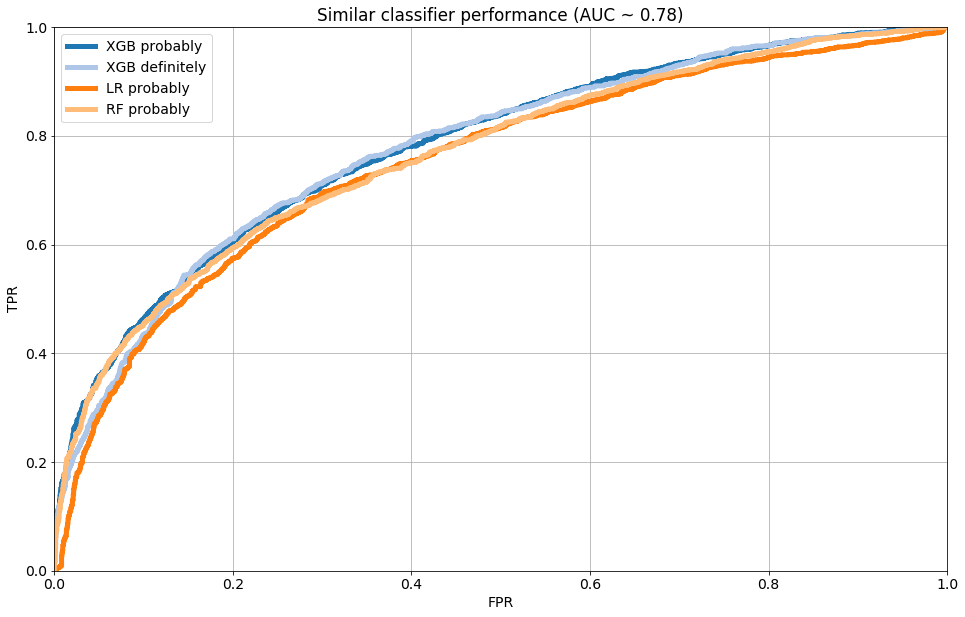

In [28]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.plot(fpr_xgb_probably, tpr_xgb_probably, lw=5, label='XGB probably')
plt.plot(fpr_xgb_definitely, tpr_xgb_definitely, lw=5, label='XGB definitely')
plt.plot(fpr_lr_probably, tpr_lr_probably, lw=5, label='LR probably')
plt.plot(fpr_rf_probably, tpr_rf_probably, lw=5, label='RF probably')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=0)
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Similar classifier performance (AUC ~ 0.78)')
fig.savefig('ROC.png', dpi=300)
plt.show();

In [29]:
competitions = pd.read_csv(os.path.join(META_DATA_PATH, 'Competitions.csv'))
competitions = competitions.rename(columns={'Id': 'CompetitionId'})
competitions = competitions[competitions.HostSegmentTitle != 'InClass']
competitions = competitions[competitions.EvaluationAlgorithmAbbreviation == 'AUC']
competitions = competitions[competitions.RewardType == 'USD']
competitions = competitions[competitions.FinalLeaderboardHasBeenVerified]
competitions = competitions[competitions.CanQualifyTiers]
competitions = competitions[competitions.RewardQuantity > 1000]
competitions = competitions[competitions.TotalTeams > 200]
competitions = competitions[['CompetitionId', 'Slug', 'Title', 'DeadlineDate',
                             'RewardQuantity', 'TotalTeams']]
competitions.shape
competitions.sort_values(by='TotalTeams', ascending=False)

(20, 6)

,CompetitionId,Slug,Title,DeadlineDate,RewardQuantity,TotalTeams
325,9120,home-credit-default-risk,Home Credit Default Risk,8/29/2018 11:59:00 PM,70000.0,7198
309,4986,santander-customer-satisfaction,Santander Customer Satisfaction,5/2/2016 11:59:00 PM,60000.0,5123
317,8540,talkingdata-adtracking-fraud-detection,TalkingData AdTracking Fraud Detection Challenge,5/7/2018 11:59:00 PM,25000.0,3951
298,5261,predicting-red-hat-business-value,Predicting Red Hat Business Value,9/19/2016 11:59:00 PM,50000.0,2271
227,4487,springleaf-marketing-response,Springleaf Marketing Response,10/19/2015 11:59:00 PM,100000.0,2226
225,4657,homesite-quote-conversion,Homesite Quote Conversion,2/8/2016 11:59:00 PM,20000.0,1764
220,3338,amazon-employee-access-challenge,Amazon.com - Employee Access Challenge,7/31/2013 11:59:00 PM,5000.0,1687
241,4031,axa-driver-telematics-analysis,Driver Telematics Analysis,3/16/2015 11:59:00 PM,30000.0,1528
231,4366,predict-west-nile-virus,West Nile Virus Prediction,6/17/2015 11:59:00 PM,40000.0,1306
245,3897,acquire-valued-shoppers-challenge,Acquire Valued Shoppers Challenge,7/14/2014 11:59:00 PM,30000.0,952


In [30]:
submissions = pd.read_csv(os.path.join(META_DATA_PATH, 'Submissions.csv'),
                          usecols=['TeamId', 'IsAfterDeadline', 'PrivateScoreFullPrecision'],
                          low_memory=False)
submissions = submissions[~submissions.IsAfterDeadline]
submissions['PrivateScoreFullPrecision'] = submissions.PrivateScoreFullPrecision.astype(np.float64)
submissions = submissions[submissions.PrivateScoreFullPrecision < 0.999]
submissions = submissions[submissions.PrivateScoreFullPrecision > 0.5]
best_submissions = submissions.groupby('TeamId')[['PrivateScoreFullPrecision']].max().reset_index()

teams = pd.read_csv(os.path.join(META_DATA_PATH, 'Teams.csv'),
                   usecols=['Id', 'CompetitionId', 'PrivateLeaderboardRank'])
teams = teams.rename(columns={'Id': 'TeamId'})
team_results = teams.merge(best_submissions, on='TeamId')
best_competition_results = team_results.groupby('CompetitionId')[['PrivateScoreFullPrecision']].max().reset_index()
competitions = competitions.merge(best_competition_results, on='CompetitionId')
competitions = competitions.sort_values(by='PrivateScoreFullPrecision')
competitions

,CompetitionId,Slug,Title,DeadlineDate,RewardQuantity,TotalTeams,PrivateScoreFullPrecision
12,3897,acquire-valued-shoppers-challenge,Acquire Valued Shoppers Challenge,7/14/2014 11:59:00 PM,30000.0,952,0.627220
13,3926,kdd-cup-2014-predicting-excitement-at-donors-c...,KDD Cup 2014 - Predicting Excitement at Donors...,7/15/2014 11:59:00 PM,2000.0,472,0.685244
7,4487,springleaf-marketing-response,Springleaf Marketing Response,10/19/2015 11:59:00 PM,100000.0,2226,0.804273
19,9120,home-credit-default-risk,Home Credit Default Risk,8/29/2018 11:59:00 PM,70000.0,7198,0.805703
14,5390,melbourne-university-seizure-prediction,Melbourne University AES/MathWorks/NIH Seizure...,12/1/2016 11:59:00 PM,20000.0,478,0.812466
17,4986,santander-customer-satisfaction,Santander Customer Satisfaction,5/2/2016 11:59:00 PM,60000.0,5123,0.829523
11,3960,seizure-prediction,American Epilepsy Society Seizure Prediction C...,11/17/2014 11:59:00 PM,25000.0,504,0.839932
9,4366,predict-west-nile-virus,West Nile Virus Prediction,6/17/2015 11:59:00 PM,40000.0,1306,0.861419
1,2551,GiveMeSomeCredit,Give Me Some Credit,12/15/2011 11:59:59 PM,5000.0,924,0.869569
3,3526,stumbleupon,StumbleUpon Evergreen Classification Challenge,10/31/2013 11:59:59 PM,5000.0,625,0.889233


In [31]:
results = pd.DataFrame({
    'Title': list(competitions.Title.values) + ['Data Science Confidence'],
    'AUC': list(competitions.PrivateScoreFullPrecision.values) + [auc_xgb_probably]
})
results = results.sort_values(by='AUC')
results.index = np.arange(len(results))

data = [
    go.Bar(
        y=results['AUC'].values,
        x=results.index,
        marker=dict(
            color=['black' if title == 'Data Science Confidence' else '#00BBFF' for title in results.Title.values],
        ),
        text=results.Title.values,
    )
]
layout = go.Layout(
    autosize=True,
    title='Most kaggle competitions are easier than predicting Data Science Confidence :)',
    hovermode='closest',
    xaxis=dict(title='Kaggle competitions', ticklen=0, zeroline=False, gridwidth=0),
    yaxis=dict(title='AUC', ticklen=5, gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='KaggleCompetitionBenchmark')